# トレーニングデータのインポート & チェック

In [11]:
# import needed file
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


In [12]:
# import data
transforms = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [01:23<00:00, 2.04MB/s] 


In [15]:
print(trainset.data.shape)
(50000, 32, 32, 3)

# テスト用データセット：縦横32ピクセルのRGBの画像が10000枚
print(testset.data.shape)
(10000, 32, 32, 3)

# クラス一覧を確認する
print(trainset.classes)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# classesはよく利用するので別途保持しておく
classes = trainset.classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 36, 138)
(36, 138, 3)


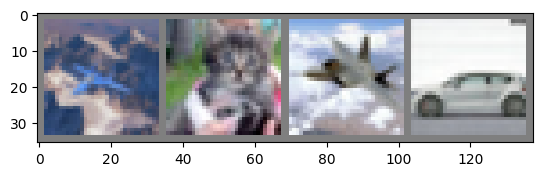

airplane   cat airplane automobile


In [19]:
def imshow(img):
    # 非正規化する
    img = img / 2 + 0.5
    # torch.Tensor型からnumpy.ndarray型に変換する
    print(type(img)) # <class 'torch.Tensor'>
    npimg = img.numpy()
    print(type(npimg))    
    # 形状を（RGB、縦、横）から（縦、横、RGB）に変換する
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    # 画像を表示する
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [87]:
# 別ファイルのimport
import sys
sys.path.append('/workspace/Vit_vs_CNN')
import cnn
import vit

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

net = cnn.CNN()


# 損失関数
criterion = nn.CrossEntropyLoss()
# CNNオプティマイザの設定
optimizer_cnn = torch.optim.SGD(cnn.parameters(),lr = 0.001, momentum=0.9)


AttributeError: module 'cnn' has no attribute 'CNN'

# ViTでの学習

# CNNでの学習

In [ ]:
from cnn import CNN

# 比較